# Oscilador anarmónico -Red neuronal informada por física (PINN)

La fuerza es del orden $-y^3$ y la energía potencial es del orden $y^4/4$

## Revisión del problema

-> La energía potencial es: $U(y) = \omega_0^2 y^4/4$, y la energía cinética es: $E_k (y) = (dy/dt)^2/2$

-> La energía total es $E = U + E_k$

-> La ecuación a resolver es: $d^2y/dt^2 + \omega_0^2 y^3 = 0$

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from __future__ import division, print_function
import sys

In [2]:
def runge_kutta4(func, r, t, omega, h):
    """ 
    Runge-Kutta 4 method for solving 1st order differential equations
    
    Usage: xNew = rk4(func, r, t, h) 
    
    Given a function  f(x, t, h) = dx/dt and initial starting 
    conditions for x, rk4() returns the next values of x. 
    func:  user defined function for the 1st order differential equations
    r: dependent variable(s)
    t: independent variable(s)
    h: independent variable step value
    """
    k1 = h*func(r, t, omega)
    k2 = h*func(r+0.5*k1, t+0.5*h, omega)
    k3 = h*func(r+0.5*k2, t+0.5*h, omega)
    k4 = h*func(r+k3, t+h, omega)
    return (k1 + 2*k2 + 2*k3 + k4)/6
   
def pendule_Function(r, t, omega):
    """ vectorized function for the pendule """
    x = r[0]
    v = r[1]
    fx = v  
    fv = - omega**2 * x**3  
    return np.array([fx,fv], float)

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generamos la solución exacta (Esquema de integración clásico) y los datos de entrenamiento

> Primero, generamos algunos datos de entrenamiento desde una pequeña parte de la verdadera solución analítica.

<function matplotlib.pyplot.show(close=None, block=None)>

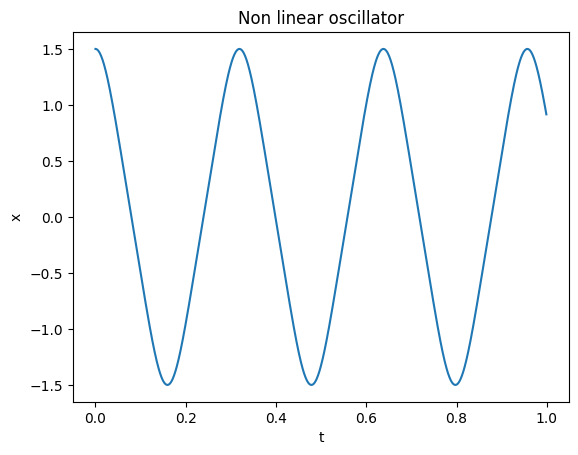

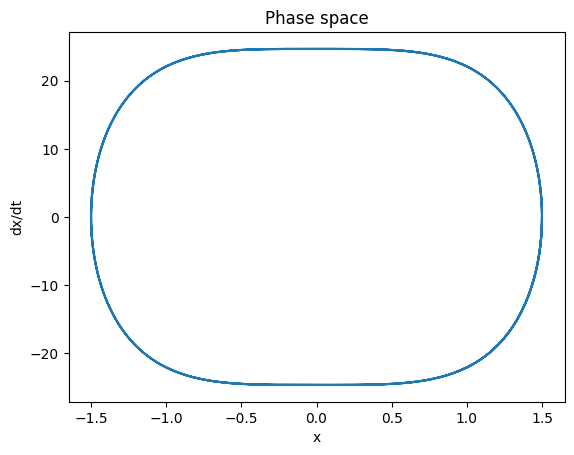

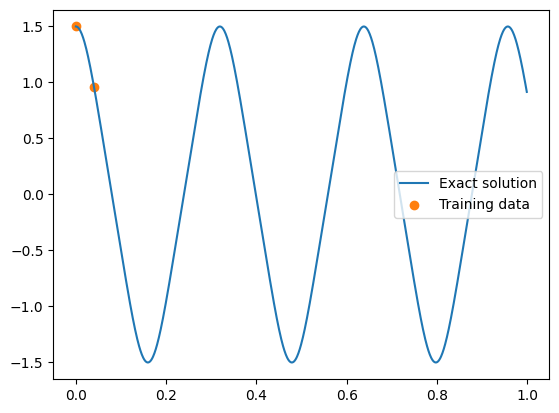

In [3]:
# We define the time step ... important also for visualization ......
nSteps=1000        # Number of time steps for RK4 integration ....
w0=15.5            # Choose the angular velocity value .........

tMin,tMax = 0.0,1.       # Time domain interval ................
tStep = (tMax-tMin)/nSteps
tPoints = np.arange(tMin, tMax, tStep)
xPoints,vPoints = [],[]

# set initial conditions on the state variables
x0,v0 = 1.5,0.0               # Choose the initial conditions x0 and derivative ........
r = np.array([x0,v0], float)

# solve for the time evolution for the true solution obtained with Runge-kutta integration
for t in tPoints:
    xPoints += [r[0]]
    vPoints += [r[1]]
    r += runge_kutta4(pendule_Function, r, t, w0, tStep)

# plot displacement vs time  (true solution)  
fig1 = plt.figure(1)
plt.plot(tPoints, xPoints)
plt.xlabel("t")
plt.ylabel("x")
plt.title("Non linear oscillator")

# plot the phase space (true solution)
fig2 = plt.figure(2)
plt.plot(xPoints, vPoints)
plt.xlabel("x")
plt.ylabel("dx/dt")
plt.title("Phase space")

x=torch.Tensor(tPoints).view(-1,1)
y=torch.Tensor(xPoints).view(-1,1)

# We slice out a small number of points from the full domain -> training data extraction ....
x_data = x[0:80:40]
y_data = y[0:80:40]

# We plot data on the true solution and training data ...................................
plt.figure()
plt.plot(tPoints, xPoints, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show

## Red neuronal normal

> Siguiente, entrenamos una red neuronal estándar (la red totalmente conectada) para ajustarla sobre estos puntos.

>Encontramos que la red es capaz de ajustar la solución muy cercanamente de un conjunto de puntos de entrenamiento, pero no aprende una solución precisa fuera de ellos.

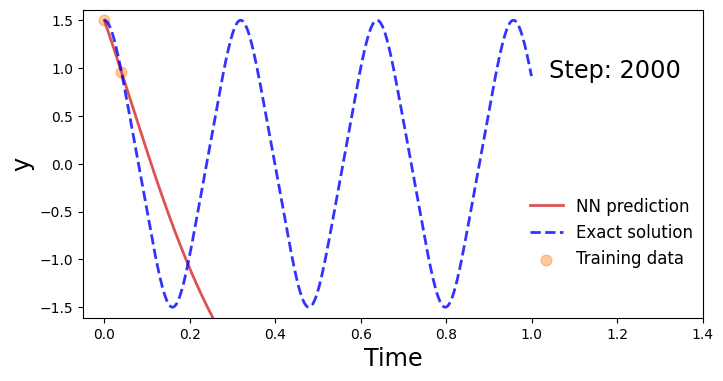

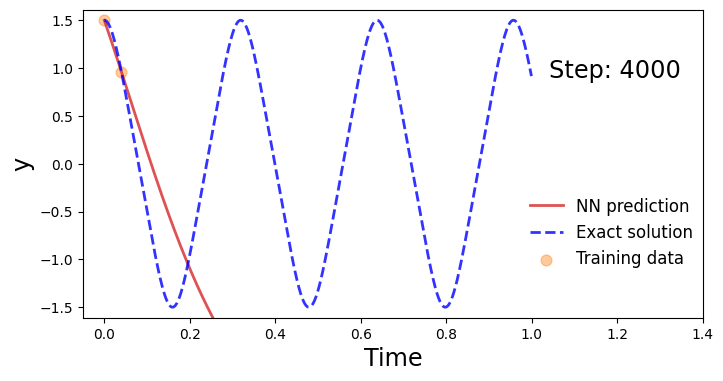

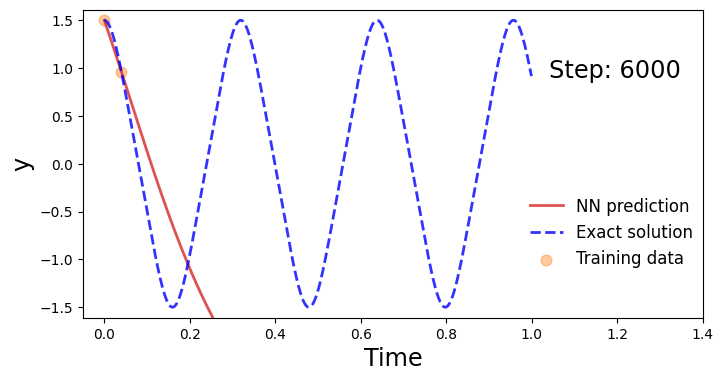

In [4]:
def plot_result(x,y,x_data,y_data,yh,xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(x,y, color="blue", linewidth=2, alpha=0.8,linestyle='--', label="Exact solution")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=30, color="tab:green", alpha=0.4, 
                    label='Coloc. points')
    l = plt.legend(loc=(0.71,0.14), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.xlim(-0.05, 1.4)
    plt.ylim(-1.61, 1.61)
    plt.text(1.04,0.9,"Step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.ylabel('y',fontsize="xx-large")
    plt.xlabel('Time',fontsize="xx-large")
    plt.axis("on")
       
# We train standard neural network to fit training data ....................
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=5e-4)
files = []
for i in range(6000):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 100 == 0: 
        
        yh = model(x).detach()        
        plot_result(tPoints,xPoints,x_data,y_data,yh)    
        if (i+1) % 2000 == 0: plt.show()
        else: plt.close("all")
            

# PINN

> Finalmente, añadimos la ecuación diferencial ("Pérdida física") a la función de pérdida.

La pérdida física se asegura que la solución aprendida es consistente con la ecuación diferencial. Esto es hecho penalizando el residuo de la ecuación deiferencial sobre un conjunto de localizaciones muestreadas desde el dominio.

Aquí evaluamos la pérdida física en 40 puntos uniformemente espaciados sobre el dominio del problema $([0,1])$. Podemos calcular las derivadas de la solución de la red con respecto a las variables de entrada en estos puntos usando la autodiferenciaciónde `pytorch`, y podemos calcularlas fácilmente los residuales de la ecuación diferencial usando estas cantidades.  

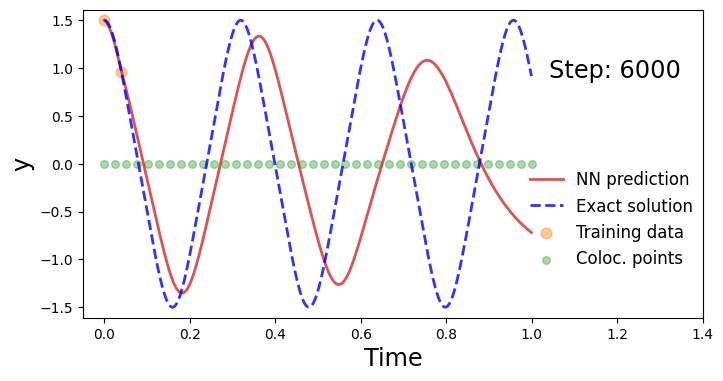

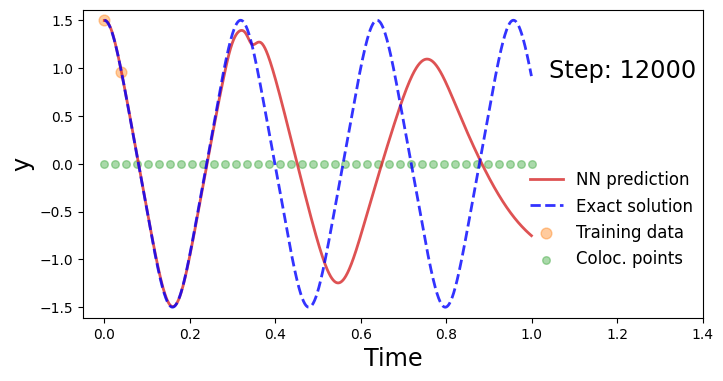

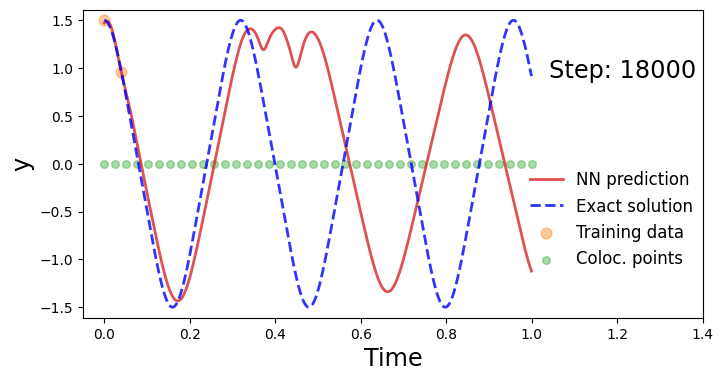

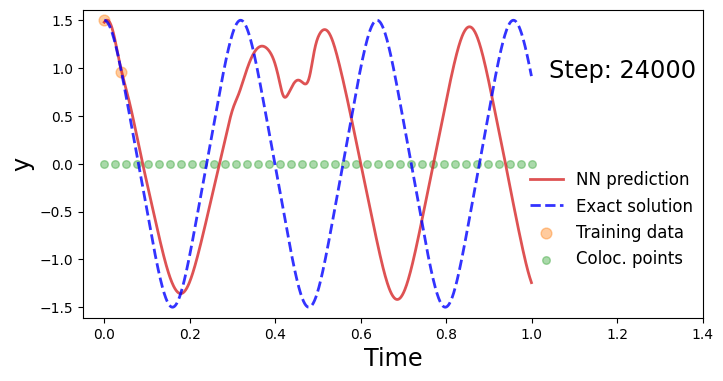

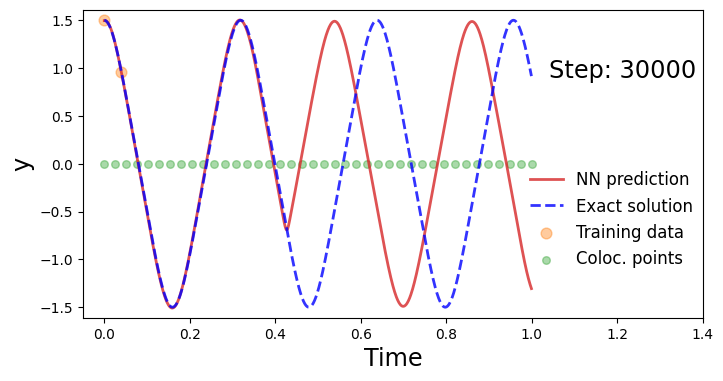

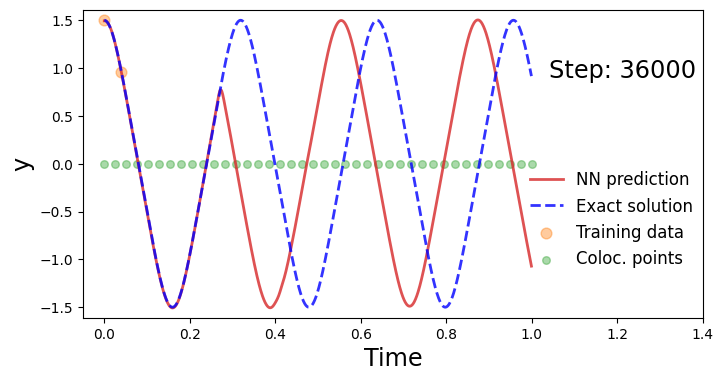

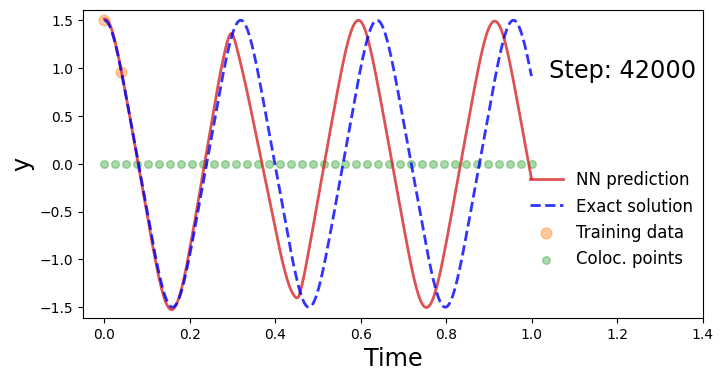

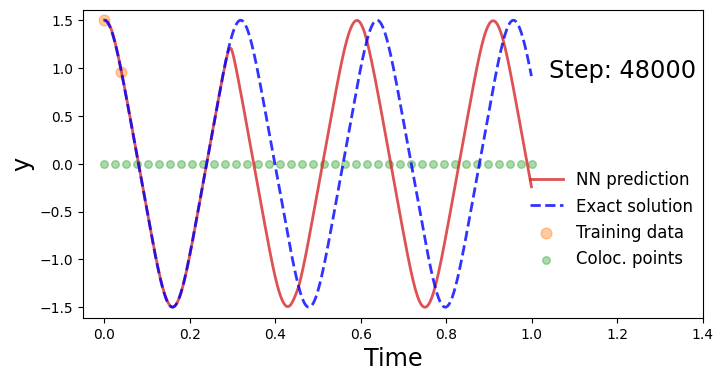

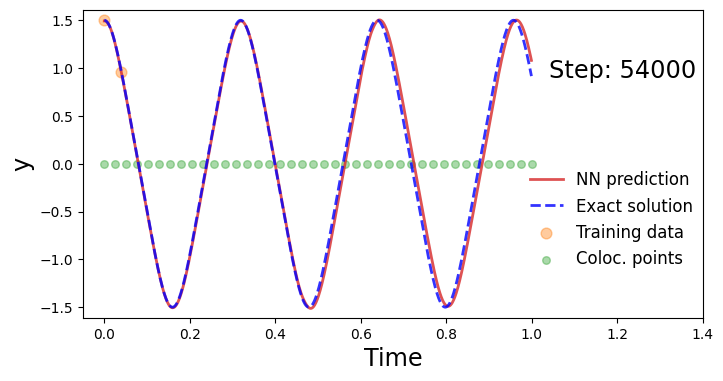

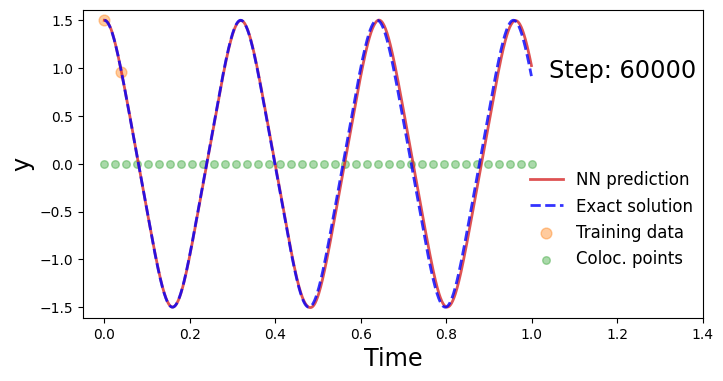

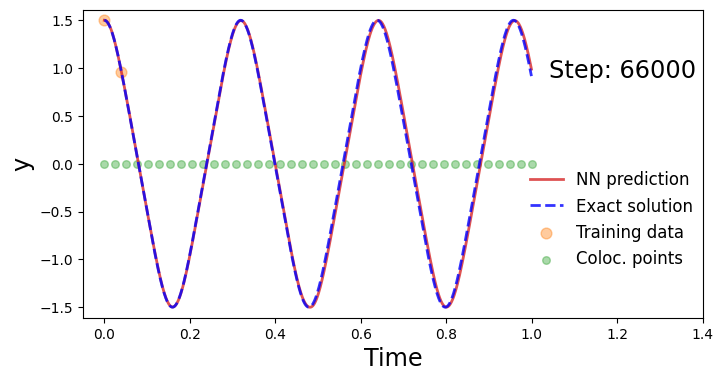

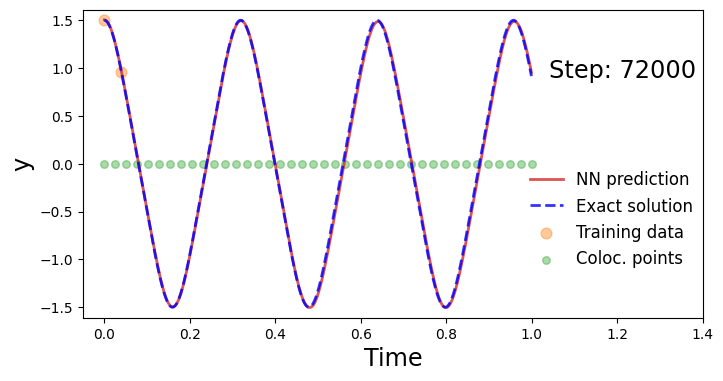

In [5]:
# We define the collocation points ...................................
x_physics = torch.linspace(0,1,40).view(-1,1).requires_grad_(True)# sample locations over the problem domain

torch.manual_seed(123)
model = FCN(1,1,32,5)
optimizer = torch.optim.Adam(model.parameters(),lr=1.1e-3)
files = []

loss1_history = []
loss2_history = []
loss3_history = []
loss_history = []

for i in range(74000):
    optimizer.zero_grad()
    
    # compute the "data loss" ...............................
    yh = model(x_data)
    loss1 = 1*torch.mean((yh-y_data)**2)# use mean squared error
    
    # compute the "physics loss" ............................
    yhp = model(x_physics)
    dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2    
    physics= (dx2 + w0**2*yhp**3)
    loss2 = (1e-5)*torch.mean(physics**2) 
    
    # compute the "energy loss" ............................
    physics2 = (dx**2/2. + w0**2*yhp**4./4. - w0**2*1.5**4./4.)
    loss3 = (1.e-6)*torch.mean(physics2**2)    
    
    # backpropagate total loss .............................
    loss = loss1 + loss2 + loss3 # add two loss terms together
    loss.backward()
    optimizer.step()
       
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        loss1_history.append(loss1.detach())
        loss2_history.append(loss2.detach())
        loss3_history.append(loss3.detach())
        loss_history.append(loss.detach())
        
        yh = model(x).detach()
        xp = x_physics.detach()
        
        plot_result(tPoints,xPoints,x_data,y_data,yh,xp)
               
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            

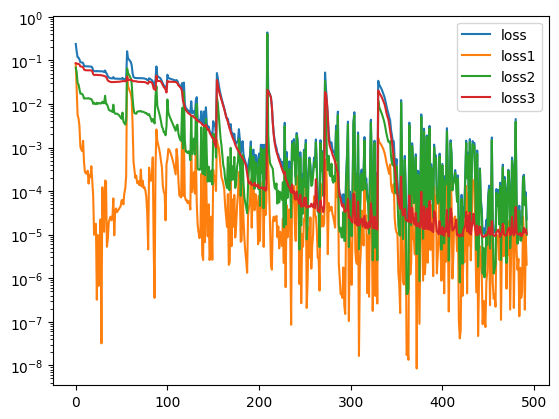

In [6]:
plt.plot(loss_history, label="loss")
plt.plot(loss1_history, label="loss1")
plt.plot(loss2_history, label="loss2")
plt.plot(loss3_history, label="loss3")
plt.yscale('log')
plt.legend()


